# LSSDS results

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from persim import plot_diagrams

from astropology.simulate import time_series
from astropology.simulate import random_remove_points
from astropology.series import pd_time_series
from astropology.distance import bottleneck_distance
from astropology.distance import wasserstein_distance
import warnings
warnings.filterwarnings("ignore")

In [2]:
def sinusoidal(t , period , amplitude=5):
    
    w = 2 * np.pi/period
    
    return amplitude * np.sin(w*t) + amplitude

# Wasserstein and Bottleneck distance versus variance of sinusoidal functions

In this section, we test how the Wasserstein distance will change when we increase the variance of sinusoidal time series. 

The control sample is a perfect sinusoidal time series with 0 variance.


In [3]:
n = 1000
period = 2*np.pi ### keep this fixed
mean_dt = 0.01

t, control_signal, _ = time_series(
    signal_function=sinusoidal,
    period=period,
    number_samples=n,
    variance = 0,
    mean_dt=mean_dt,
    irregular_dt=0,
)
pd_control = pd_time_series(control_signal)

# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
# axs[0].plot(t, control_signal)
# plot_diagrams(pd_control)

In [4]:
n_variances = 30
variances = np.logspace(np.log10(0.01), np.log10(25), n_variances)

noisy_signals = np.empty((n_variances, control_signal.size))
pds_noisy_signals = []

for idx, variance in enumerate(variances):

    _, signal_noisy, _ = time_series(
    signal_function=sinusoidal,
    period=period,
    number_samples=n,
    variance = variance,
    mean_dt=mean_dt,
    irregular_dt=0,
    )

    noisy_signals[idx, :] = signal_noisy

    pd_noisy = pd_time_series(signal_noisy)
    pds_noisy_signals.append(pd_noisy)


In [5]:
w_distances = np.empty(n_variances)
b_distances = np.empty(n_variances)

for idx, pd_noisy in enumerate(pds_noisy_signals):
    
    b_distances[idx] = bottleneck_distance(pd_control, pd_noisy)
    w_distances[idx] = wasserstein_distance(pd_control, pd_noisy)
    

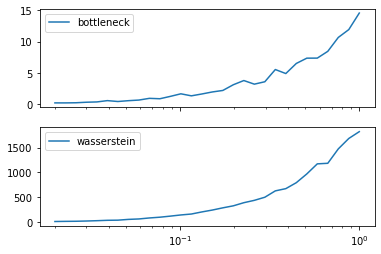

In [6]:
stds = np.sqrt(variances)

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True) #, figsize=(10, 5))

axs[0].plot(stds/5, b_distances, label='bottleneck')
# axs[0].set_xscale('log')
# axs[0].set_xlim(1e-2, 1)

axs[1].plot(stds/5, w_distances, label='wasserstein')
# axs[1].set_xscale('log')
# axs[1].set_xlim(1e-2, 1)
_ = [ax.legend() for ax in axs]
_ = [ax.set_xscale('log') for ax in axs]


# Influence of cadence on Wasserstein and Bottleneck distance
In this example we use a sinusoidal time series as a control series and remove points randomly to see what happens with the distances between persistence diagrams

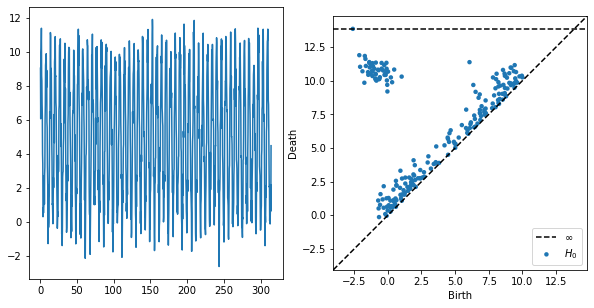

In [7]:
n = 1000
period = 2*np.pi ### keep this fixed
variance = 1.
mean_dt = 0.05

t, control_signal, _ = time_series(
    signal_function=sinusoidal,
    period=period,
    number_samples=n,
    variance = variance,
    mean_dt=mean_dt,
    irregular_dt=0,
)

pd_control = pd_time_series(control_signal)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(t, control_signal)
plot_diagrams(pd_control)


In [10]:
removal_percentages = np.linspace(0, 99, 100)
cadence_length = control_signal.size 
cadences = []
signals = []
pdgms = []

w_distances_cadence = np.empty(removal_percentages.size)
b_distances_cadence = np.empty(removal_percentages.size)

pd_control = pd_control[np.isfinite(pd_control[:, 1]), :]

for idx, remove_percentage in enumerate(removal_percentages):
    
    cadence_mask = random_remove_points(
        cadence_length, remove_percentage
    )

    t_new = t[cadence_mask]
    signal_new = control_signal[cadence_mask]

    # cadences.append(t_new)
    # signals.append(signal_new)

    pd_new = pd_time_series(signal_new)
    pd_new = pd_new[np.isfinite(pd_new[:, 1]), :]

    # pdgms.append(pd_new)

    w_distances_cadence[idx] = wasserstein_distance(
        pd_control, pd_new
    )

    b_distances_cadence[idx] = bottleneck_distance(
        pd_control, pd_new
    )

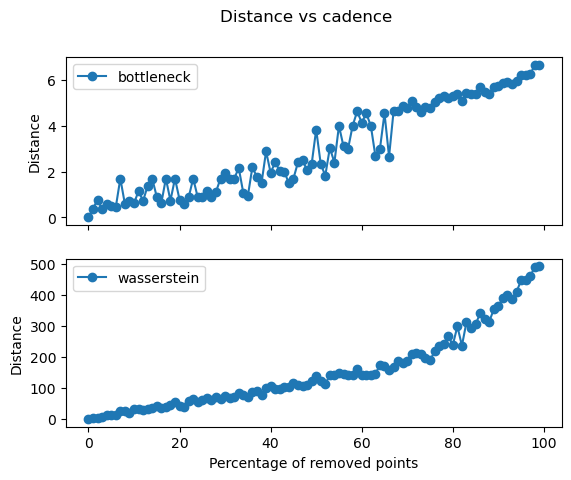

In [11]:
fig, axs = plt.subplots(
    nrows=2, ncols=1, sharex=True,
    # figsize=(10, 5))
)
fig.suptitle("Distance vs cadence")

axs[0].plot(
    removal_percentages, b_distances_cadence, '-o',
    label='bottleneck'
)
axs[0].set_ylabel("Distance")
# axs[0].set_xscale('log')
# axs[0].set_xlim(1e-2, 1)

axs[1].plot(
    removal_percentages, w_distances_cadence, '-o',
    label='wasserstein'
)
axs[1].set_ylabel("Distance")
axs[1].set_xlabel("Percentage of removed points")
# axs[1].set_xscale('log')
# axs[1].set_xlim(1e-2, 1)
_ = [ax.legend() for ax in axs]
# _ = [ax.set_xscale('log') for ax in axs]